<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Best_Old_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [3]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с текстом
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.probability import FreqDist
from nltk.corpus import wordnet, stopwords
from pymystem3 import Mystem

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Работа с данными

## Основные данные

Считаем данные

In [4]:
df = pd.read_csv("./data/train/train_issues.csv")

Работа со временем

In [5]:
df['created_time'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')
df['month'] = df['created_time'].dt.month
df['day'] = df['created_time'].dt.day
df['hour'] = df['created_time'].dt.hour
df['minute'] = df['created_time'].dt.minute

df.drop(['created', 'created_time'], axis=1, inplace=True)

Работа с ключем задачи

In [6]:
df['key_name'] = df['key'].apply(lambda x: x.split('-')[0])
df['key_num'] = df['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df.drop(['key'], axis=1, inplace=True)
df.head()

,id,summary,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour,minute,key_name,key_num
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,10,1,5,57,SM,10678
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,10,1,5,59,SM,10679
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,10,1,6,0,SM,10680
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,10,1,6,2,SM,10682
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,10,1,6,3,SM,10683


Работа с описанием задачи

In [7]:
m = Mystem()
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Для того чтобы лемматизация работала, необходимо раскомментировать первые две строки при первом запуске

In [8]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
# !tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

In [9]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\' ]', ' ', text)
    t = ' '.join(t.split())
    return t

def lemmatize_text_rus(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_with_pos_eng(text):
    pos_tagged = nltk.pos_tag(w_tokenizer.tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


df['clear_summary'] = df['summary'].apply(clear_text)
df['clear_summary'] = df['clear_summary'].str.lower()
df['lemm_summary'] = df['clear_summary'].apply(lemmatize_text_rus)
df['lemm_summary'] = df['lemm_summary'].apply(lemmatize_with_pos_eng)

df.drop(['summary', 'clear_summary'], axis=1, inplace=True)

Эти стоп-слова пригодятся нам в дальнейшем при использовании tf-idf

In [10]:
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

count_tf_idf = TfidfVectorizer(stop_words=stopwords_all)

Преобразуем таргет, чтобы исключить выбросы и минимизировать разброс

In [11]:
df['log_target'] = np.log(df['overall_worklogs'])
df.drop(['overall_worklogs'], axis=1, inplace=True)

## Присоединяем дополнительные данные

### Информация о работниках

Считаем данные

In [12]:
df_emp = pd.read_csv("./data/employees.csv")

Сразу отбросим бесполезное

In [13]:
df_emp.drop(['english_level', 'salary_calculation_type', 'full_name'],
            axis=1, inplace=True)

In [14]:
df_emp['payment_type'].fillna('unknown', inplace=True)
df_emp['hiring_type'].fillna('unknown', inplace=True)

In [15]:
def position_cleaning(x):
    if x is np.NaN:
        return x
    
    x = x.lower().strip().replace('-', ' ')

    key_positions = ['web', 'директор', 'руководитель',
                     'devops', 'рекрутер', 'бухгалтер',
                     'hr', 'тестировщик']

    for key_pos in key_positions:
        if key_pos in x:
            x = key_pos
            break
    
    if x == 'рекрутер' or x == 'специалист отдела по управлению персоналом' or x == 'сорсер':
        return 'hr'
    elif x == 'графический дизайнер':
        return 'web'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(position_cleaning)
pos_pop = df_emp['position'].value_counts()

In [16]:
def remark_pos(x):
    if x is np.NaN or pos_pop[x] < 3:
        return 'other'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(remark_pos)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,other,unknown,unknown,0,0,0,0,0
1,2,0,web,staff,fixed,0,0,0,0,0
2,4,0,web,staff,fixed,0,0,0,0,0
3,6,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,8,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


Присоединяем информацию о работниках

In [17]:
df = pd.merge(df, df_emp, left_on="assignee_id", right_on="id",
              how='left', suffixes=('', '_y'))

# df.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [18]:
df.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,...,log_target,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,819952,5,93,93,10,1,5,57,SM,10678,...,7.495542,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
1,819949,5,93,93,10,1,5,59,SM,10679,...,8.881836,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
2,819947,5,93,93,10,1,6,0,SM,10680,...,9.574983,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
3,819943,5,93,93,10,1,6,2,SM,10682,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
4,819941,5,93,93,10,1,6,3,SM,10683,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


### Информация о комментариях

In [19]:
df_coms = pd.read_csv("./data/train/train_comments.csv")

In [20]:
df_coms_counts = df_coms.groupby('issue_id').agg({'comment_id': 'count',
                                                  'author_id': 'nunique'})
df_coms_counts.reset_index(inplace=True)
df_coms_counts.rename(columns={"comment_id":"comments_cnt",
                               "author_id":"authors_cnt"},
                      inplace=True)
df_coms_counts.head()

,issue_id,comments_cnt,authors_cnt
0,669666,1,1
1,669670,1,1
2,670930,3,1
3,670934,3,1
4,675979,5,1


In [21]:
df = pd.merge(df, df_coms_counts, left_on="id", right_on="issue_id", how='left')
df.drop(['id', 'issue_id'], axis=1, inplace=True)

In [22]:
df['comments_cnt'] = df['comments_cnt'].fillna(0).astype('int32')
df['authors_cnt'] = df['authors_cnt'].fillna(0).astype('int32')
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,1,1


## Разделение данных

In [23]:
X = df.drop(['log_target'], axis=1)
# X = df.drop(['log_target', 'lemm_summary'], axis=1)
y = df[['log_target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train = y_train.values
y_val = y_val.values
X_train.shape, X_val.shape

((8150, 21), (1439, 21))

In [24]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,48,1,1,4,16,18,15,ADBKRK,746,please check contact,...,other,unknown,unknown,0,0,0,0,0,1,1
1,13,86,86,3,4,8,45,BALT,4424,add loader for dropdowns in ib curriculum wiza...,...,web,staff,fixed,1,1,1,1,1,0,0
2,13,86,86,9,8,11,6,BALT,7867,refactore the code add improvement and fix bug,...,web,staff,fixed,1,1,1,1,1,0,0
3,13,365,193,9,1,16,16,BALT,7725,text not align in preview mode on the canvas,...,web,staff,hourly,1,1,1,1,1,0,0
4,13,365,365,10,14,12,38,BALT,8552,bug after close background selector on canvas,...,web,staff,hourly,1,1,1,1,1,0,0


Применяем tf-idf

In [25]:
X_train_new = count_tf_idf.fit_transform(X_train['lemm_summary'])
feature_names_tf = list(map(lambda x: x + '_tf', count_tf_idf.get_feature_names_out()))

X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf)
X_train.drop('lemm_summary', axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_new_df], axis=1)

X_val_new = count_tf_idf.transform(X_val['lemm_summary'])
X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf)
X_val.drop('lemm_summary', axis=1, inplace=True)
X_val = pd.concat([X_val, X_val_new_df], axis=1)

X_train.shape, X_val.shape

((8150, 4357), (1439, 4357))

In [26]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,эндпоинтов_tf,эндпойнт_tf,энергосбережение_tf,это_tf,эффект_tf,юзер_tf,юнит_tf,ядро_tf,язык_tf,ящик_tf
0,48,1,1,4,16,18,15,ADBKRK,746,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,86,86,3,4,8,45,BALT,4424,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,86,86,9,8,11,6,BALT,7867,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,365,193,9,1,16,16,BALT,7725,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,365,365,10,14,12,38,BALT,8552,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Применяем Label Encoding (так как ключевыми моделями будут деревья и их производные, то выбор справедлив)

In [27]:
cat_features = ['key_name', 'position',
                'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)
X_train[cat_features] = ord_encoder.fit_transform(X_train[cat_features])
X_val[cat_features] = ord_encoder.transform(X_val[cat_features])

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8150 entries, 0 to 8149
Columns: 4357 entries, project_id to ящик_tf
dtypes: float64(4341), int32(2), int64(14)
memory usage: 270.9 MB


# Работа с моделью

In [29]:
model = XGBRegressor(max_depth=21, random_state=59)
model.fit(X_train, y_train)

[19:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=21, random_state=59)

In [30]:
pred = model.predict(X_val)
score = r2_score(y_val, pred)
score

0.260475407778201

## Анализ модели

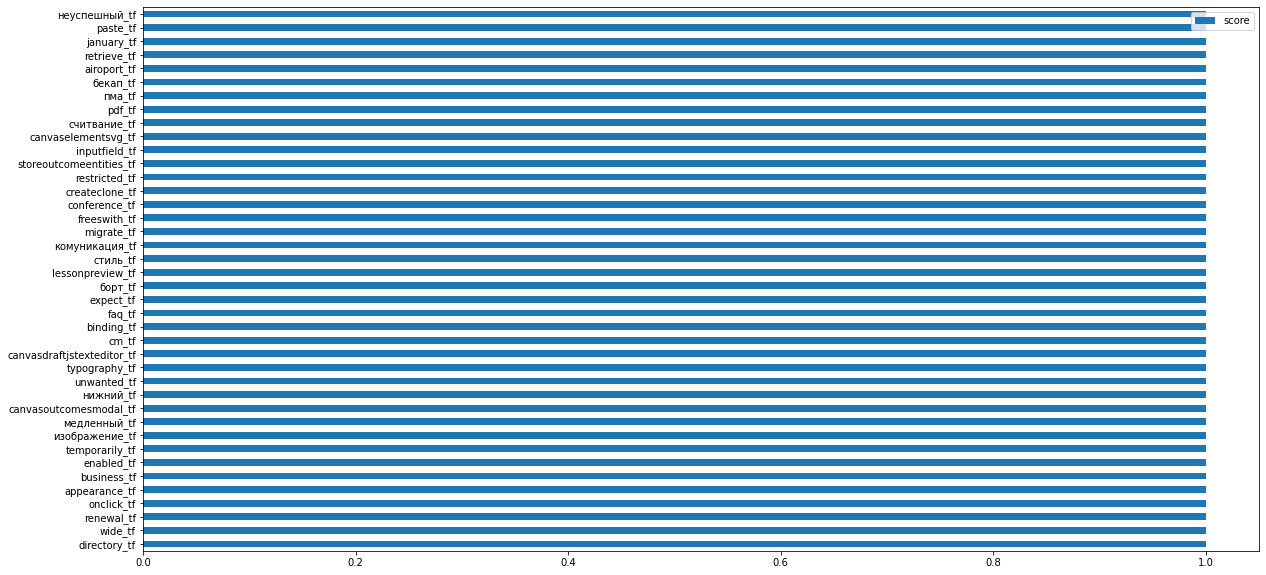

In [31]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)
data.nsmallest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

In [32]:
data

,score
assignee_id,1530
minute,1454
key_num,1418
day,1366
month,1061
...,...
question_tf,1
siren_tf,1
jackfruit_tf,1
isntances_tf,1


In [33]:
feature_importance

{'key_num': 1418,
 'topic_tf': 15,
 'kanban_tf': 7,
 'finallize_tf': 3,
 'вода_tf': 4,
 'task_tf': 43,
 'assignee_id': 1530,
 'layout_tf': 51,
 'comments_cnt': 391,
 'communication_tf': 35,
 'key_name': 66,
 'alias_tf': 3,
 'context_tf': 9,
 'асинхронность_tf': 7,
 'creator_id': 748,
 'скрывать_tf': 14,
 'month': 1061,
 'break_tf': 9,
 'prod_tf': 2,
 'repo_tf': 6,
 'grant_tf': 3,
 'package_tf': 5,
 'ctrl_tf': 7,
 'dont_tf': 3,
 'getclonedphasesections_tf': 3,
 'mandrill_tf': 3,
 'mistake_tf': 2,
 'ui_tf': 22,
 'usage_tf': 7,
 'roman_tf': 1,
 'ldp_tf': 1,
 'automatically_tf': 15,
 'documentation_tf': 22,
 'вкладывать_tf': 4,
 'водитель_tf': 8,
 'коммуникация_tf': 29,
 'click_tf': 20,
 'json_tf': 14,
 'run_tf': 4,
 'введение_tf': 5,
 'включение_tf': 8,
 'заглавный_tf': 2,
 'список_tf': 13,
 'format_tf': 4,
 'index_tf': 22,
 'исходник_tf': 8,
 'active': 41,
 'payment_type': 67,
 'access_tf': 35,
 'версия_tf': 9,
 'admins_tf': 3,
 'protect_tf': 2,
 'px_tf': 2,
 'raise_tf': 2,
 'urgent_tf':

# Сабмит на сайт

## Обработка тестовых данных

Считаем данные

In [34]:
df_test = pd.read_csv("./data/test/test_issues.csv")

In [35]:
df_test['created_time'] = pd.to_datetime(df_test['created'], format='%Y-%m-%d %H:%M:%S')
df_test['month'] = df_test['created_time'].dt.month
df_test['day'] = df_test['created_time'].dt.day
df_test['hour'] = df_test['created_time'].dt.hour
df_test['minute'] = df_test['created_time'].dt.minute

df_test['key_name'] = df_test['key'].apply(lambda x: x.split('-')[0])
df_test['key_num'] = df_test['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df_test['clear_summary'] = df_test['summary'].apply(clear_text)
df_test['clear_summary'] = df_test['clear_summary'].str.lower()
df_test['lemm_summary'] = df_test['clear_summary'].apply(lemmatize_text_rus)
df_test['lemm_summary'] = df_test['lemm_summary'].apply(lemmatize_with_pos_eng)

df_test = pd.merge(df_test, df_emp, left_on="assignee_id", right_on="id",
                   how='left', suffixes=('', '_y'))

df_test.drop(['created', 'created_time'], axis=1, inplace=True)
# df_test.drop(['key', 'key_num'], axis=1, inplace=True)
df_test.drop(['key'], axis=1, inplace=True)
df_test.drop(['summary', 'clear_summary'], axis=1, inplace=True)
df_test.drop(['id_y'], axis=1, inplace=True)
# df_test.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
# df_test.drop(['lemm_summary', 'id_y'], axis=1, inplace=True)

df_test.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,0,devops,staff,fixed,0,0,0,0,0
1,675972,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,0,devops,staff,fixed,0,0,0,0,0
2,675965,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
3,675961,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,675955,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,1,other,unknown,unknown,0,0,0,0,0


In [36]:
df_coms_test = pd.read_csv('./data/test/test_comments.csv')
df_coms_counts_test = df_coms_test.groupby('issue_id').agg({'comment_id': 'count',
                                                            'author_id': 'nunique'})
df_coms_counts_test.reset_index(inplace=True)
df_coms_counts_test.rename(columns={"comment_id":"comments_cnt",
                                    "author_id":"authors_cnt"},
                           inplace=True)
df_coms_counts_test.head()

,issue_id,comments_cnt,authors_cnt
0,670929,1,1
1,675825,1,1
2,675831,2,1
3,675834,1,1
4,675836,1,1


In [37]:
df_test = pd.merge(df_test, df_coms_counts_test,
                   left_on="id", right_on="issue_id", how='left')
df_test.drop(['id', 'issue_id'], axis=1, inplace=True)
df_test['comments_cnt'] = df_test['comments_cnt'].fillna(0).astype('int32')
df_test['authors_cnt'] = df_test['authors_cnt'].fillna(0).astype('int32')
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,...,devops,staff,fixed,0,0,0,0,0,8,1
1,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,...,devops,staff,fixed,0,0,0,0,0,4,2
2,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,...,разработчик мобильных приложений,staff,fixed,0,0,0,0,0,1,1
3,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,...,разработчик мобильных приложений,staff,fixed,0,0,0,0,0,2,2
4,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,...,other,unknown,unknown,0,0,0,0,0,7,2


In [38]:
X_test_new = count_tf_idf.transform(df_test['lemm_summary'])
X_test_new_df = pd.DataFrame(X_test_new.toarray(), columns=feature_names_tf)
df_test.drop('lemm_summary', axis=1, inplace=True)
X_test = pd.concat([df_test, X_test_new_df], axis=1)

# X_test = df_test
X_test[cat_features] = ord_encoder.transform(X_test[cat_features])
X_test.shape

(1070, 4357)

In [39]:
pred_test = np.rint(np.exp(model.predict(X_test))).astype('int64')
pred_test

array([ 9932,  5247,  9941, ...,  4570,  4839, 13998])

### Создаем датафрейм с предсказанием

In [40]:
df_sample = pd.read_csv('./data/sample_solution.csv')
len(pred_test), len(df_sample)

(1070, 1070)

In [41]:
df_sample.overall_worklogs = pred_test
df_sample.to_csv('./solutions/xgb_tfidf_d21.csv', index=False)

### Проверяем предсказание

In [42]:
df_solution = pd.read_csv('./solutions/xgb_tfidf_d21.csv')
df_solution.head()

,id,overall_worklogs
0,675975,9932
1,675972,5247
2,675965,9941
3,675961,5019
4,675955,12024


In [43]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,9805.279439
std,2.869125e+05,22355.524135
min,6.709290e+05,973.000000
25%,7.208912e+05,4971.000000
50%,7.213915e+05,6921.000000
75%,7.217428e+05,9935.000000
max,2.183553e+06,664906.000000


In [44]:
df_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1070 non-null   int64
 1   overall_worklogs  1070 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB


# Махинации со средним

Преобразуем к тренировочному распределению

In [45]:
df = pd.read_csv("./data/train/train_issues.csv")

orig_mean = int(df.overall_worklogs.mean())
sol_mean = int(df_solution.overall_worklogs.mean())
orig_mean, sol_mean

(17243, 9805)

In [46]:
def transform_dist(x):
    x = x + orig_mean - sol_mean
    return x

In [47]:
df_solution['overall_worklogs'] = df_solution['overall_worklogs'].apply(transform_dist)
df_solution.head()

,id,overall_worklogs
0,675975,17370
1,675972,12685
2,675965,17379
3,675961,12457
4,675955,19462


In [48]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,17243.279439
std,2.869125e+05,22355.524135
min,6.709290e+05,8411.000000
25%,7.208912e+05,12409.000000
50%,7.213915e+05,14359.000000
75%,7.217428e+05,17373.000000
max,2.183553e+06,672344.000000


In [49]:
df_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1070 non-null   int64
 1   overall_worklogs  1070 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB


In [50]:
df_solution.to_csv('./solutions/d21_only_mean_trans.csv', index=False)

Проверка предсказания

In [51]:
df_solution = pd.read_csv('./solutions/d21_only_mean_trans.csv')
df_solution.head()

,id,overall_worklogs
0,675975,17370
1,675972,12685
2,675965,17379
3,675961,12457
4,675955,19462


# Псевдо лейблинг

In [58]:
X_train['target'] = y_train
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,эндпойнт_tf,энергосбережение_tf,это_tf,эффект_tf,юзер_tf,юнит_tf,ядро_tf,язык_tf,ящик_tf,target
0,48,1,1,4,16,18,15,1.0,746,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.802395
1,13,86,86,3,4,8,45,3.0,4424,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.314700
2,13,86,86,9,8,11,6,3.0,7867,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.278493
3,13,365,193,9,1,16,16,3.0,7725,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.802395
4,13,365,365,10,14,12,38,3.0,8552,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.901007


In [59]:
X_val['target'] = y_val
X_val.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,эндпойнт_tf,энергосбережение_tf,это_tf,эффект_tf,юзер_tf,юнит_tf,ядро_tf,язык_tf,ящик_tf,target
0,13,10,10,8,26,8,24,3.0,1923,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.188689
1,13,242,242,9,10,13,22,3.0,7936,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.392662
2,13,11,11,2,5,6,4,3.0,4061,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.999619
3,13,68,68,6,26,12,59,3.0,1392,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.594154
4,13,11,193,6,29,6,11,3.0,6042,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.021271


In [60]:
X_test['target'] = np.log(df_solution['overall_worklogs'])
X_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,эндпойнт_tf,энергосбережение_tf,это_tf,эффект_tf,юзер_tf,юнит_tf,ядро_tf,язык_tf,ящик_tf,target
0,5,112,112,1,15,9,52,6.0,11140,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.762500
1,5,112,112,1,15,9,54,6.0,11141,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.448175
2,5,94,54,1,16,4,46,6.0,11144,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.763018
3,5,94,94,1,16,11,12,6.0,11146,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.430038
4,5,1,54,1,17,5,19,6.0,11150,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.876219


In [61]:
df = pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True)
df.shape

(10659, 4358)

In [62]:
df.isna().sum().sum()

0

In [64]:
X = df.drop(['target'], axis=1)
y = df['target'].values
X.shape, y.shape

((10659, 4357), (10659,))

In [65]:
model = XGBRegressor(max_depth=21, random_state=59)
model.fit(X, y)

[19:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=21, random_state=59)

## Новое предсказание

In [66]:
X_test.drop(['target'], axis=1, inplace=True)

In [67]:
prediction_site = model.predict(X_test)
prediction_site = np.exp(prediction_site)
prediction_site = np.rint(prediction_site).astype('int64')
prediction_site

array([16028, 14192, 12773, ...,  7091,  6987, 16645])

In [68]:
df_solution = pd.read_csv('./data/sample_solution.csv')
df_solution.overall_worklogs = prediction_site
len(prediction_site), len(df_solution)

(1070, 1070)

In [69]:
df_solution.to_csv('./solutions/BEST_PL.csv', index=False)

## Проверка нового предсказания

In [70]:
df_solution = pd.read_csv('./solutions/BEST_PL.csv')
df_solution.head()

,id,overall_worklogs
0,675975,16028
1,675972,14192
2,675965,12773
3,675961,11972
4,675955,16359


In [71]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,15599.114019
std,2.869125e+05,15047.625006
min,6.709290e+05,6416.000000
25%,7.208912e+05,11837.750000
50%,7.213915e+05,13485.000000
75%,7.217428e+05,15542.000000
max,2.183553e+06,422246.000000
